In [1]:
# Imports needed
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_directory = pathlib.Path("dataset")  #Mushroom_Datasets

image_count = len(list(dataset_directory.glob('*/*.jpg'))) #+ list(dataset_directory.glob('*/*.png'))) 
print(image_count)

13611


In [3]:
batch_size = 16
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle="True",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 13611 files belonging to 3 classes.
Using 10889 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle="True",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 13611 files belonging to 3 classes.
Using 2722 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Cortinarius', 'Lactarius', 'Russula']


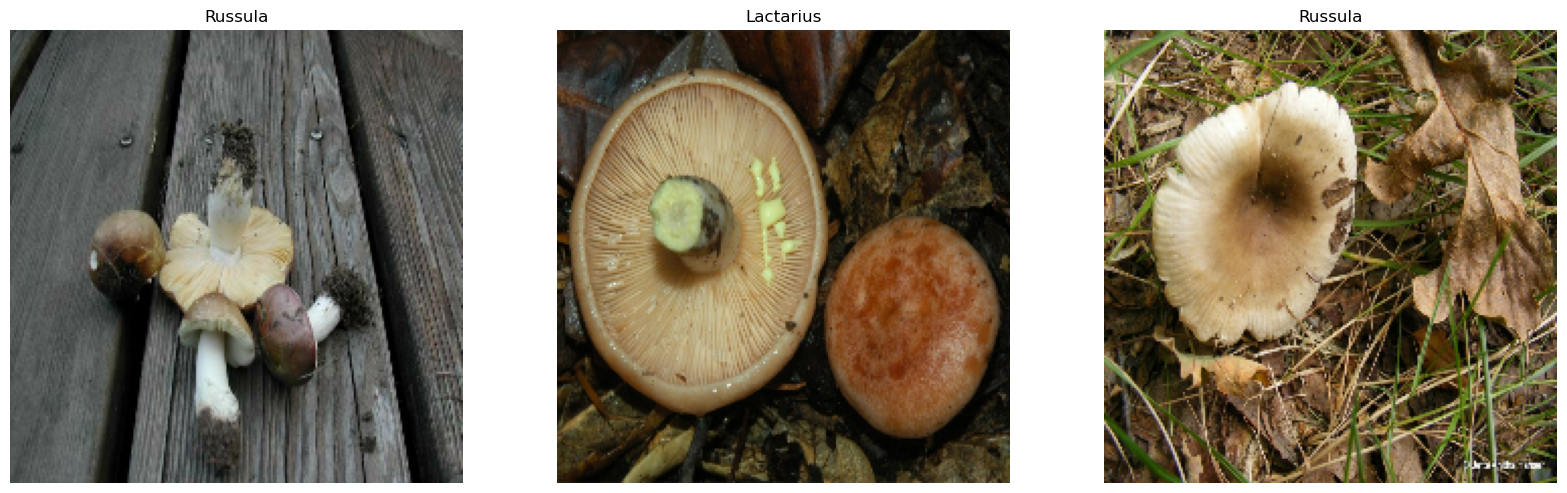

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(3): #5
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


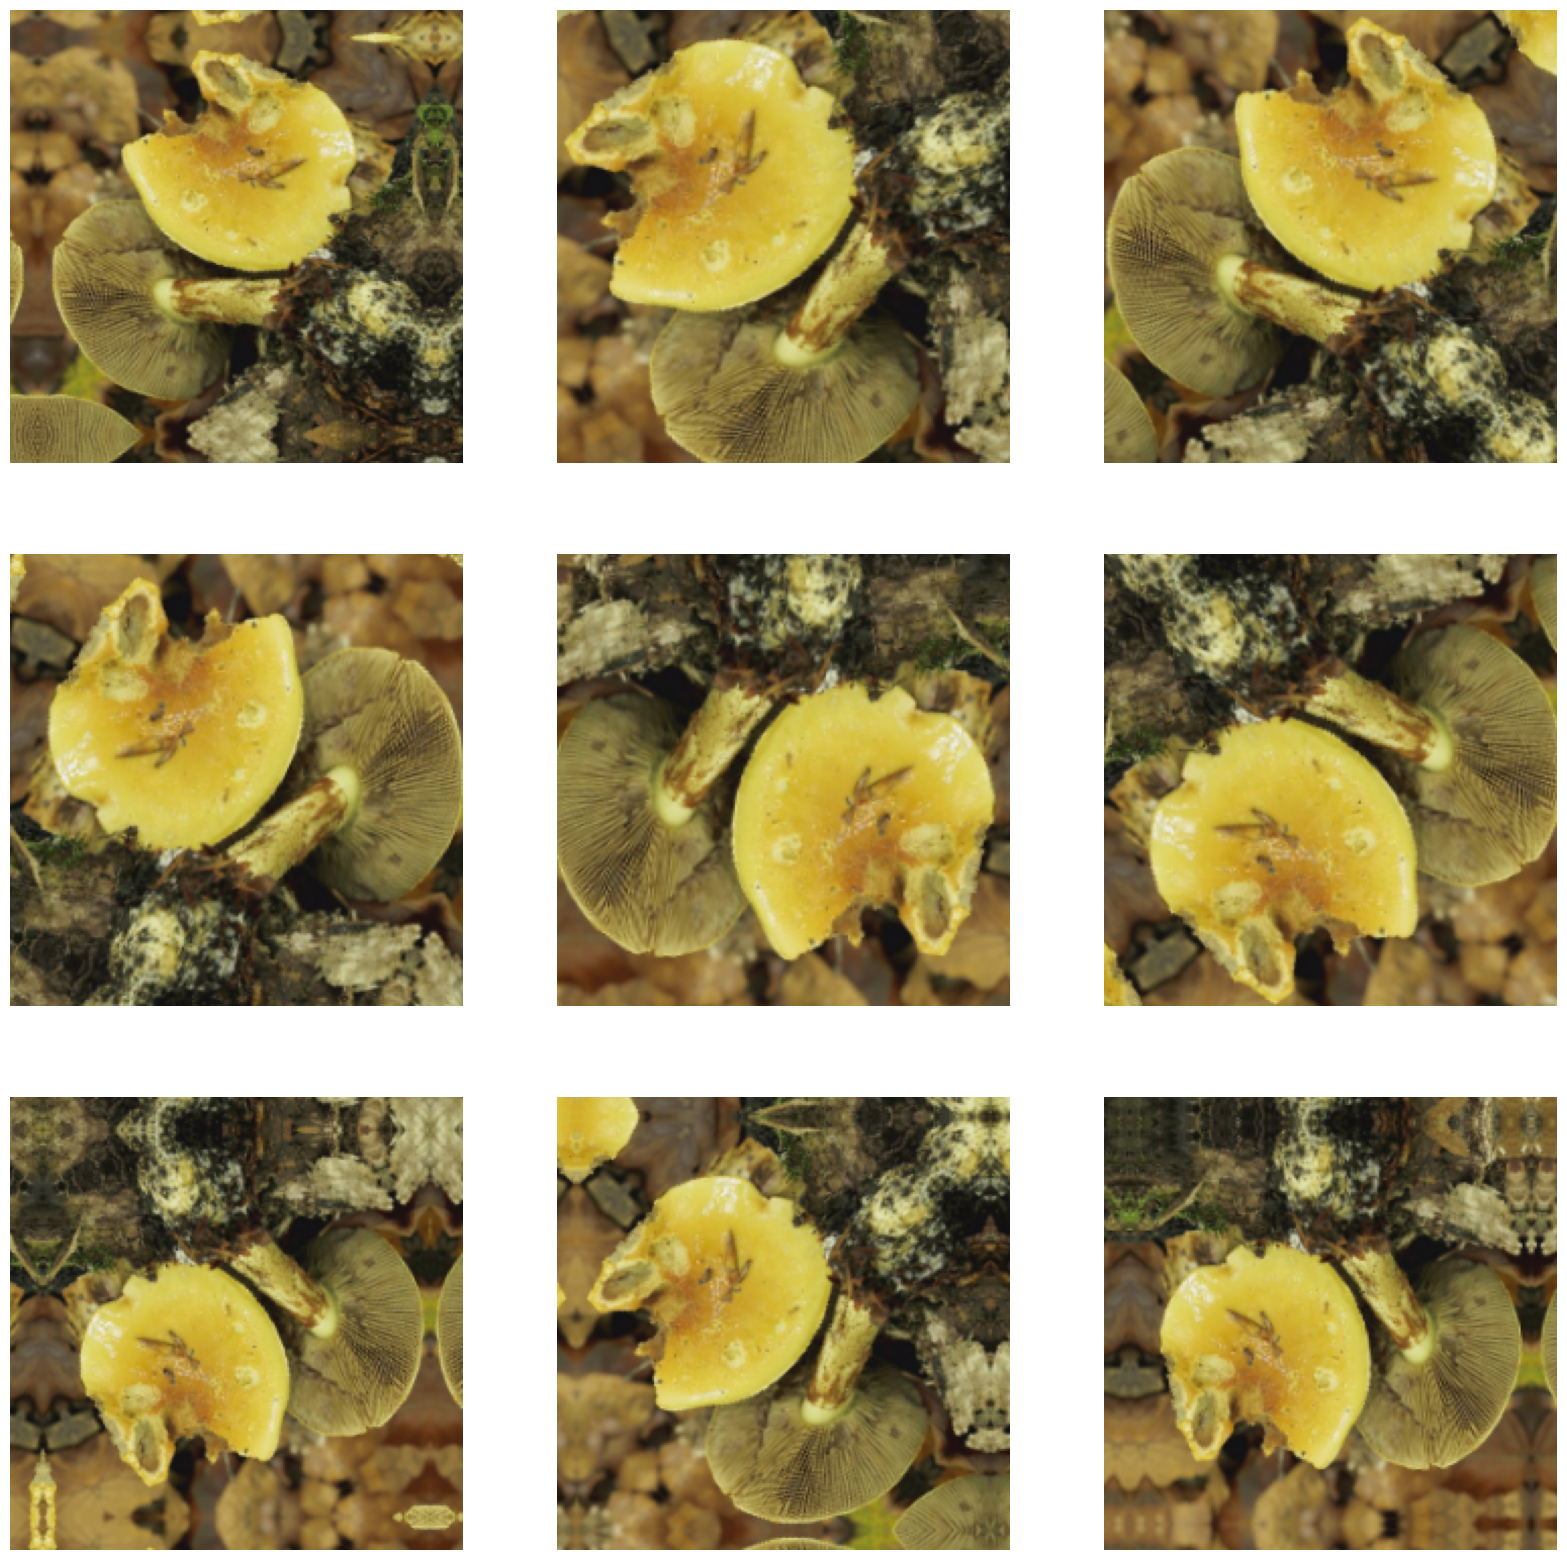

In [18]:
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)

In [23]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint, early, reduce_lr],
)

Epoch 1/20
681/681 [==============================] - ETA: 0s - loss: 1.0288 - accuracy: 0.4847
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to Model.h5
681/681 [==============================] - 301s 438ms/step - loss: 1.0288 - accuracy: 0.4847 - val_loss: 1.0214 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/20
681/681 [==============================] - ETA: 0s - loss: 0.9614 - accuracy: 0.5369
Epoch 2: val_accuracy improved from 0.50000 to 0.53747, saving model to Model.h5
681/681 [==============================] - 351s 515ms/step - loss: 0.9614 - accuracy: 0.5369 - val_loss: 0.9821 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 3/20
681/681 [==============================] - ETA: 0s - loss: 0.9228 - accuracy: 0.5698
Epoch 3: val_accuracy improved from 0.53747 to 0.57458, saving model to Model.h5
681/681 [==============================] - 332s 488ms/step - loss: 0.9228 - accuracy: 0.5698 - val_loss: 0.9296 - val_accuracy: 0.5746 - lr: 1.0000e-04
Epoch 4/20
681/6

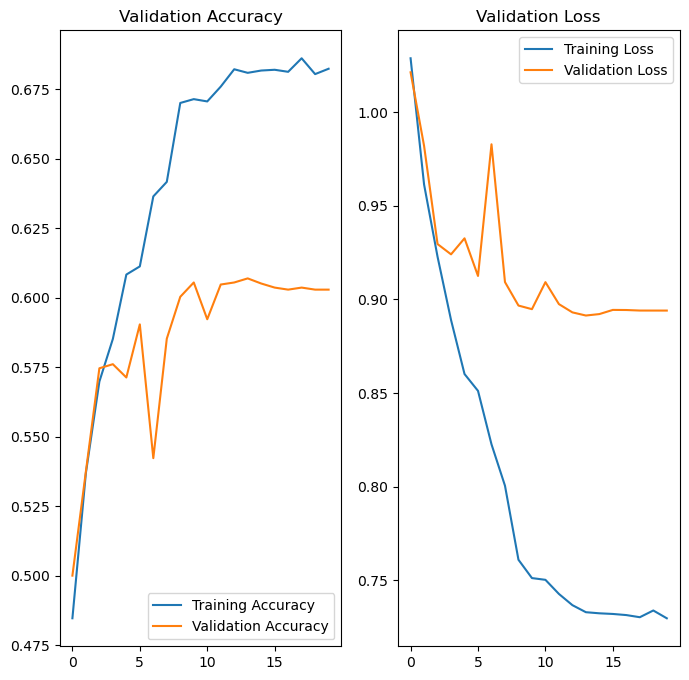

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right') 
plt.title('Training Accuracy')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.title('Validation Loss')
plt.show()

In [5]:
testing_directory = pathlib.Path("TestingDatasets")

testing_files = list(testing_directory.glob('*.jpg')) #+ list(dataset_directory.glob('*/*.png'))

for file in testing_files:
    image = tf.keras.preprocessing.image.load_img(file, target_size=(img_height, img_width))

    image_array = tf.keras.utils.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0) # Create a batch

    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])

    #plt.imshow(image)

    print(
        "This {} most likely belongs to {} with a {:.2f} percent confidence."
        .format(file, class_names[np.argmax(score)], 100 * np.max(score))
    ) 

NameError: name 'pathlib' is not defined